In [127]:
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image

In [129]:
@torch.no_grad()
def test(hn, hf, dataset, step, chunk_size=10, img_index=0, nb_bins=192, H=400, W=400):

    ray_origins = dataset[img_index * H * W: (img_index + 1) * H * W, :3]       # select image at img_index
    ray_directions = dataset[img_index * H * W: (img_index + 1) * H * W, 3:6]   # select respective ray directions

    data = []
    
    for i in range(int(np.ceil(H / chunk_size))):
        ray_origins_ = ray_origins[i * W * chunk_size: (i + 1) * W * chunk_size].to(device)     # select a chunk of the image
        ray_directions_ = ray_directions[i * W * chunk_size: (i + 1) * W * chunk_size].to(device)       # select the corresponding ray directions
        regenerated_px_values = render_rays(model, ray_origins_, ray_directions_, step, hn=hn, hf=hf, nb_bins=nb_bins)      # predict the pixel values using the model
        data.append(regenerated_px_values)      # append the predict chunk to recreate the image
    img = torch.cat(data).data.cpu().numpy().reshape(H, W, 3)

    plt.figure()
    plt.imshow(img)
    plt.savefig(f'novel_views/img_{img_index}_v1.png', bbox_inches='tight')
    plt.close()


class NerfModel(nn.Module):
    def __init__(self, embedding_dim_pos=16, embedding_dim_direction=4, hidden_dim=128, T=40_000):
        super(NerfModel, self).__init__()

        self.block1 = nn.Sequential(nn.Linear(embedding_dim_pos * 6 + 3, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), )
        self.block2 = nn.Sequential(nn.Linear(embedding_dim_pos * 6 + hidden_dim + 3, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim + 1), )
        self.block3 = nn.Sequential(nn.Linear(embedding_dim_direction * 6 + hidden_dim + 3, hidden_dim // 2),
                                    nn.ReLU(), )
        self.block4 = nn.Sequential(nn.Linear(hidden_dim // 2, 3), nn.Sigmoid(), )

        self.embedding_dim_pos = embedding_dim_pos
        self.embedding_dim_direction = embedding_dim_direction
        self.relu = nn.ReLU()
        self.T = T

    def positional_encoding(self, x, L, step, is_pos=False):
        out = [x]
        for j in range(L):
            out.append(torch.sin(2 ** j * x))
            out.append(torch.cos(2 ** j * x))
        out = torch.cat(out, dim=1)

        Lmax = 2 * 3 * L + 3
        if is_pos:
            out[:, int(step / self.T * Lmax) + 3:] = 0.
        return out

    def forward(self, o, d, step):

        emb_x = self.positional_encoding(o, self.embedding_dim_pos, step, is_pos=True)
        emb_d = self.positional_encoding(d, self.embedding_dim_direction, step, is_pos=False)
        h = self.block1(emb_x)
        tmp = self.block2(torch.cat((h, emb_x), dim=1))
        h, sigma = tmp[:, :-1], torch.nn.functional.softplus(tmp[:, -1])
        h = self.block3(torch.cat((h, emb_d), dim=1))
        c = self.block4(h)
        
        return c, sigma


def compute_accumulated_transmittance(alphas):
    accumulated_transmittance = torch.cumprod(alphas, 1)
    return torch.cat((torch.ones((accumulated_transmittance.shape[0], 1), device=alphas.device),
                      accumulated_transmittance[:, :-1]), dim=-1)


def render_rays(nerf_model, ray_origins, ray_directions, step, hn=0, hf=0.5, nb_bins=192):

    # nb_bins number of samples taken on the rays

    device = ray_origins.device
    t = torch.linspace(hn, hf, nb_bins, device=device).expand(ray_origins.shape[0], nb_bins)
    # Perturb sampling along each ray.

    mid = (t[:, :-1] + t[:, 1:]) / 2.
    lower = torch.cat((t[:, :1], mid), -1)
    upper = torch.cat((mid, t[:, -1:]), -1)
    u = torch.rand(t.shape, device=device)
    t = lower + (upper - lower) * u  # [batch_size, nb_bins]
    delta = torch.cat((t[:, 1:] - t[:, :-1], torch.tensor([1e10], device=device).expand(ray_origins.shape[0], 1)), -1)

    x = ray_origins.unsqueeze(1) + t.unsqueeze(2) * ray_directions.unsqueeze(1)  # [batch_size, nb_bins, 3]
    ray_directions = ray_directions.expand(nb_bins, ray_directions.shape[0], 3).transpose(0, 1)
    colors, sigma = nerf_model(x.reshape(-1, 3), ray_directions.reshape(-1, 3), step)
    colors = colors.reshape(x.shape)
    sigma = sigma.reshape(x.shape[:-1])

    alpha = 1 - torch.exp(-sigma * delta)  # [batch_size, nb_bins]
    weights = compute_accumulated_transmittance(1 - alpha).unsqueeze(2) * alpha.unsqueeze(2)
    c = (weights * colors).sum(dim=1)  # Pixel values
    weight_sum = weights.sum(-1).sum(-1)  # Regularization for white background
    return c + 1 - weight_sum.unsqueeze(-1)


def sample_batch(data, batch_size, device):
    # Random sampling on first axis (rows/height) of input images. Selects batch_size rows
    idx = torch.randperm(data.shape[0])[:batch_size]
    return torch.from_numpy(data[idx]).to(device)


def train(nerf_model, optimizer, training_data, nb_epochs, batch_size, device='cpu', hn=0, hf=1, nb_bins=192):
    training_loss = []
    for step in tqdm(range(nb_epochs)):
        batch = sample_batch(training_data, batch_size, device)

        rays_o = batch[:, :3].to(device)
        rays_d = batch[:, 3:6].to(device)
        ground_truth_px_values = batch[:, 6:].to(device)

        regenerated_px_values = render_rays(nerf_model, rays_o, rays_d, step, hn=hn, hf=hf, nb_bins=nb_bins)
        loss = ((ground_truth_px_values - regenerated_px_values) ** 2).sum()
        training_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return training_loss

def calc_o(r = 1 , theta = 0 , phi = 0):

    x = r*np.cos(phi)*np.cos(theta)
    y = r*np.cos(phi)*np.sin(theta)
    z = r*np.sin(phi)

    return np.array([x,y,z])

def calc_d0(f=20 , height=400 , width=500):

    y = np.linspace(-height//2, height//2, height).astype(np.int32)
    z = np.linspace(-width//2, width//2, width).astype(np.int32)

    dirs = np.meshgrid(z , y)

    return dirs

def calc_d(d0 , cam_xyz):

    d_cam = np.array([-cam_xyz[0] , -cam_xyz[1] , -cam_xyz[2]] , ndmin=2)
    d = d0 + np.reshape(d_cam[0 , 1:3] , newshape=(2,1,1))
    x = cam_xyz[0] * np.ones(shape=(1 , d.shape[1] , d.shape[2]))
    d = np.concatenate((x , d) , axis=0)

    return d

if __name__ == '__main__':
    device = "mps"
    # training_dataset = torch.from_numpy(np.load('training_data.pkl', allow_pickle=True))
    # testing_dataset = torch.from_numpy(np.load('testing_data.pkl', allow_pickle=True))
    nb_epochs = 80_000

    # img0 = training_dataset[26 * 400 * 400:(26 + 1) * 400 * 400]
    # img2 = training_dataset[86 * 400 * 400:(86 + 1) * 400 * 400]
    # img3 = training_dataset[2 * 400 * 400:(2 + 1) * 400 * 400]
    # img4 = training_dataset[55 * 400 * 400:(55 + 1) * 400 * 400]
    # img5 = training_dataset[75 * 400 * 400:(75 + 1) * 400 * 400]
    # img6 = training_dataset[93 * 400 * 400:(93 + 1) * 400 * 400]
    # img7 = training_dataset[16 * 400 * 400:(16 + 1) * 400 * 400]
    # img8 = training_dataset[73 * 400 * 400:(73 + 1) * 400 * 400]

    img1 =  (np.array(Image.open("data/1.jpg"))[:2252,:2252,:])
    img2 = (np.array(Image.open("data/2.jpg"))[:2252,:2252,:])
    img3 = (np.array(Image.open("data/3.jpg"))[:2252,:2252,:])
    img4 = (np.array(Image.open("data/4.jpg"))[:2252,:2252,:])

    o1 = (calc_o(r=1 , theta=0 , phi=np.pi/4)*np.ones(shape=img1.shape)).flatten()
    o2 = (calc_o(r=1 , theta=np.pi/2 , phi=np.pi/4)*np.ones(shape=img2.shape)).flatten()
    o3 = (calc_o(r=1 , theta=np.pi , phi=np.pi/4)*np.ones(shape=img3.shape)).flatten()
    o4 = (calc_o(r=1 , theta=(3*np.pi)/2 , phi=np.pi/4)*np.ones(shape=img4.shape)).flatten()

    d0 = calc_d0(20 , img1.shape[0] , img1.shape[1])
    d1 = (calc_d(d0 , calc_o(r=1 , theta=0 , phi=np.pi/4))).flatten()
    d2 = (calc_d(d0 , calc_o(r=1 , theta=np.pi/2 , phi=np.pi/4))).flatten()
    d3 = (calc_d(d0 , calc_o(r=1 , theta=np.pi , phi=np.pi/4))).flatten()
    d4 = (calc_d(d0 , calc_o(r=1 , theta=(3*np.pi)/2 , phi=np.pi/4))).flatten()

    e1 = np.concatenate((o1 , d1 , img1.flatten()))
    e2 = np.concatenate((o2 , d2 , img2.flatten()))
    e3 = np.concatenate((o3 , d3 , img3.flatten()))
    e4 = np.concatenate((o4 , d4 , img4.flatten()))

    training_data = np.concatenate((e1,e2,e3,e4))
    training_data = training_data.reshape((-1,9))
    training_data = training_data.astype(np.float32)

    model = NerfModel(hidden_dim=256, T=nb_epochs // 2).to(device)
    model_optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
    train(model, model_optimizer, training_data, nb_epochs, 1024, device=device, hn=2, hf=6, nb_bins=192)
    # for img_index in range(200):
    #     test(2, 6, testing_dataset, nb_epochs, img_index=img_index, nb_bins=192, H=400, W=400)

  0%|          | 0/80000 [00:00<?, ?it/s]

torch.Size([1024, 9])


  0%|          | 2/80000 [00:11<108:58:38,  4.90s/it]

torch.Size([1024, 9])


  0%|          | 3/80000 [00:12<68:40:44,  3.09s/it] 

torch.Size([1024, 9])


  0%|          | 4/80000 [00:13<49:48:04,  2.24s/it]

torch.Size([1024, 9])


  0%|          | 5/80000 [00:14<39:17:45,  1.77s/it]

torch.Size([1024, 9])


  0%|          | 6/80000 [00:15<33:02:01,  1.49s/it]

torch.Size([1024, 9])


  0%|          | 7/80000 [00:16<29:00:47,  1.31s/it]

torch.Size([1024, 9])


  0%|          | 8/80000 [00:17<26:23:04,  1.19s/it]

torch.Size([1024, 9])
torch.Size([1024, 9])


  0%|          | 10/80000 [00:19<23:37:16,  1.06s/it]

torch.Size([1024, 9])


  0%|          | 11/80000 [00:20<22:47:47,  1.03s/it]

torch.Size([1024, 9])


  0%|          | 12/80000 [00:21<22:22:26,  1.01s/it]

torch.Size([1024, 9])


  0%|          | 13/80000 [00:22<21:54:49,  1.01it/s]

torch.Size([1024, 9])


  0%|          | 14/80000 [00:23<21:45:36,  1.02it/s]

torch.Size([1024, 9])


  0%|          | 15/80000 [00:23<21:45:36,  1.02it/s]

torch.Size([1024, 9])


  0%|          | 16/80000 [00:24<21:39:27,  1.03it/s]

torch.Size([1024, 9])


  0%|          | 17/80000 [00:25<21:41:37,  1.02it/s]

torch.Size([1024, 9])


  0%|          | 18/80000 [00:26<21:33:05,  1.03it/s]

torch.Size([1024, 9])


  0%|          | 19/80000 [00:27<21:35:17,  1.03it/s]

torch.Size([1024, 9])


  0%|          | 20/80000 [00:28<21:32:30,  1.03it/s]

torch.Size([1024, 9])


  0%|          | 21/80000 [00:29<21:20:30,  1.04it/s]

torch.Size([1024, 9])


  0%|          | 22/80000 [00:30<21:28:07,  1.03it/s]

torch.Size([1024, 9])


  0%|          | 23/80000 [00:31<21:33:56,  1.03it/s]

torch.Size([1024, 9])


  0%|          | 24/80000 [00:32<21:40:39,  1.02it/s]

torch.Size([1024, 9])


  0%|          | 25/80000 [00:33<21:33:22,  1.03it/s]

torch.Size([1024, 9])


  0%|          | 26/80000 [00:34<21:31:14,  1.03it/s]

torch.Size([1024, 9])


  0%|          | 27/80000 [00:35<21:31:48,  1.03it/s]

torch.Size([1024, 9])


  0%|          | 28/80000 [00:36<21:38:42,  1.03it/s]

torch.Size([1024, 9])


  0%|          | 29/80000 [00:37<21:38:43,  1.03it/s]

torch.Size([1024, 9])


  0%|          | 30/80000 [00:38<21:32:19,  1.03it/s]

torch.Size([1024, 9])


  0%|          | 31/80000 [00:39<21:26:53,  1.04it/s]

torch.Size([1024, 9])


  0%|          | 32/80000 [00:40<21:22:06,  1.04it/s]

torch.Size([1024, 9])


  0%|          | 33/80000 [00:41<21:17:13,  1.04it/s]

torch.Size([1024, 9])


  0%|          | 34/80000 [00:42<21:00:41,  1.06it/s]

torch.Size([1024, 9])


  0%|          | 35/80000 [00:43<20:53:35,  1.06it/s]

torch.Size([1024, 9])


  0%|          | 36/80000 [00:44<21:02:44,  1.06it/s]

torch.Size([1024, 9])


  0%|          | 37/80000 [00:45<21:13:24,  1.05it/s]

torch.Size([1024, 9])


  0%|          | 38/80000 [00:46<21:19:39,  1.04it/s]

torch.Size([1024, 9])


  0%|          | 39/80000 [00:47<21:16:21,  1.04it/s]

torch.Size([1024, 9])


  0%|          | 40/80000 [00:48<21:11:05,  1.05it/s]

torch.Size([1024, 9])


  0%|          | 41/80000 [00:48<21:13:09,  1.05it/s]

torch.Size([1024, 9])


  0%|          | 42/80000 [00:49<21:13:03,  1.05it/s]

torch.Size([1024, 9])


  0%|          | 43/80000 [00:50<21:03:52,  1.05it/s]

torch.Size([1024, 9])


  0%|          | 44/80000 [00:51<21:00:34,  1.06it/s]

torch.Size([1024, 9])


  0%|          | 45/80000 [00:52<20:58:11,  1.06it/s]

torch.Size([1024, 9])


  0%|          | 46/80000 [00:53<20:55:03,  1.06it/s]

torch.Size([1024, 9])


  0%|          | 47/80000 [00:54<20:55:15,  1.06it/s]

torch.Size([1024, 9])


  0%|          | 48/80000 [00:55<21:00:18,  1.06it/s]

torch.Size([1024, 9])


  0%|          | 49/80000 [00:56<21:14:14,  1.05it/s]

torch.Size([1024, 9])


  0%|          | 50/80000 [00:57<21:21:19,  1.04it/s]

torch.Size([1024, 9])


  0%|          | 51/80000 [00:58<21:05:59,  1.05it/s]

torch.Size([1024, 9])


  0%|          | 52/80000 [00:59<20:59:44,  1.06it/s]

torch.Size([1024, 9])


  0%|          | 53/80000 [01:00<21:08:52,  1.05it/s]

torch.Size([1024, 9])


  0%|          | 54/80000 [01:01<21:15:29,  1.04it/s]

torch.Size([1024, 9])


  0%|          | 55/80000 [01:02<21:07:36,  1.05it/s]

torch.Size([1024, 9])


  0%|          | 56/80000 [01:03<20:59:16,  1.06it/s]

torch.Size([1024, 9])


  0%|          | 57/80000 [01:04<20:57:51,  1.06it/s]

torch.Size([1024, 9])


  0%|          | 58/80000 [01:05<20:55:32,  1.06it/s]

torch.Size([1024, 9])


  0%|          | 59/80000 [01:06<21:02:13,  1.06it/s]

torch.Size([1024, 9])


  0%|          | 60/80000 [01:07<21:14:32,  1.05it/s]

torch.Size([1024, 9])


  0%|          | 61/80000 [01:08<21:20:46,  1.04it/s]

torch.Size([1024, 9])


  0%|          | 62/80000 [01:08<21:29:36,  1.03it/s]

torch.Size([1024, 9])


  0%|          | 63/80000 [01:09<21:13:15,  1.05it/s]

torch.Size([1024, 9])


  0%|          | 64/80000 [01:10<21:03:32,  1.05it/s]

torch.Size([1024, 9])


  0%|          | 65/80000 [01:11<20:57:37,  1.06it/s]

torch.Size([1024, 9])


  0%|          | 66/80000 [01:12<21:01:02,  1.06it/s]

torch.Size([1024, 9])


  0%|          | 67/80000 [01:13<21:00:15,  1.06it/s]

torch.Size([1024, 9])
torch.Size([1024, 9])


  0%|          | 69/80000 [01:15<21:17:23,  1.04it/s]

torch.Size([1024, 9])


  0%|          | 70/80000 [01:16<21:13:33,  1.05it/s]

torch.Size([1024, 9])


  0%|          | 71/80000 [01:17<21:13:36,  1.05it/s]

torch.Size([1024, 9])


  0%|          | 72/80000 [01:18<21:19:21,  1.04it/s]

torch.Size([1024, 9])


  0%|          | 73/80000 [01:19<21:24:26,  1.04it/s]

torch.Size([1024, 9])


  0%|          | 74/80000 [01:20<21:09:23,  1.05it/s]

torch.Size([1024, 9])


  0%|          | 75/80000 [01:21<21:12:27,  1.05it/s]

torch.Size([1024, 9])


  0%|          | 76/80000 [01:22<21:13:21,  1.05it/s]

torch.Size([1024, 9])


  0%|          | 77/80000 [01:23<21:17:32,  1.04it/s]

torch.Size([1024, 9])


  0%|          | 78/80000 [01:24<21:18:16,  1.04it/s]

torch.Size([1024, 9])


  0%|          | 79/80000 [01:25<21:32:07,  1.03it/s]

torch.Size([1024, 9])


  0%|          | 80/80000 [01:26<21:37:09,  1.03it/s]

torch.Size([1024, 9])


  0%|          | 81/80000 [01:27<21:48:00,  1.02it/s]

torch.Size([1024, 9])
torch.Size([1024, 9])


  0%|          | 83/80000 [01:29<21:53:34,  1.01it/s]

torch.Size([1024, 9])
torch.Size([1024, 9])


  0%|          | 85/80000 [01:31<21:53:27,  1.01it/s]

torch.Size([1024, 9])


  0%|          | 86/80000 [01:32<21:35:37,  1.03it/s]

torch.Size([1024, 9])


  0%|          | 86/80000 [01:32<23:51:42,  1.07s/it]


KeyboardInterrupt: 

In [125]:
def calc_o(r = 1 , theta = 0 , phi = 0):

    x = r*np.cos(phi)*np.cos(theta)
    y = r*np.cos(phi)*np.sin(theta)
    z = r*np.sin(phi)

    return np.array([x,y,z])

def calc_d0(f=20 , height=400 , width=500):

    y = np.linspace(-height//2, height//2, height).astype(np.int32)
    z = np.linspace(-width//2, width//2, width).astype(np.int32)

    dirs = np.meshgrid(z , y)

    return dirs

def calc_d(d0 , cam_xyz):

    d_cam = np.array([-cam_xyz[0] , -cam_xyz[1] , -cam_xyz[2]] , ndmin=2)
    d = d0 + np.reshape(d_cam[0 , 1:3] , newshape=(2,1,1))
    x = cam_xyz[0] * np.ones(shape=(1 , d.shape[1] , d.shape[2]))
    d = np.concatenate((x , d) , axis=0)

    return d

from PIL import Image

img1 =  (np.array(Image.open("data/1.jpg"))[:2252,:2252,:])
img2 = (np.array(Image.open("data/2.jpg"))[:2252,:2252,:])
img3 = (np.array(Image.open("data/3.jpg"))[:2252,:2252,:])
img4 = (np.array(Image.open("data/4.jpg"))[:2252,:2252,:])

o1 = (calc_o(r=1 , theta=0 , phi=np.pi/4)*np.ones(shape=img1.shape)).flatten()
o2 = (calc_o(r=1 , theta=np.pi/2 , phi=np.pi/4)*np.ones(shape=img2.shape)).flatten()
o3 = (calc_o(r=1 , theta=np.pi , phi=np.pi/4)*np.ones(shape=img3.shape)).flatten()
o4 = (calc_o(r=1 , theta=(3*np.pi)/2 , phi=np.pi/4)*np.ones(shape=img4.shape)).flatten()

d0 = calc_d0(20 , img1.shape[0] , img1.shape[1])
d1 = (calc_d(d0 , calc_o(r=1 , theta=0 , phi=np.pi/4))).flatten()
d2 = (calc_d(d0 , calc_o(r=1 , theta=np.pi/2 , phi=np.pi/4))).flatten()
d3 = (calc_d(d0 , calc_o(r=1 , theta=np.pi , phi=np.pi/4))).flatten()
d4 = (calc_d(d0 , calc_o(r=1 , theta=(3*np.pi)/2 , phi=np.pi/4))).flatten()

print(o1.shape , d1.shape , img1.flatten().shape)

e1 = np.concatenate((o1 , d1 , img1.flatten()))
e2 = np.concatenate((o2 , d2 , img2.flatten()))
e3 = np.concatenate((o3 , d3 , img3.flatten()))
e4 = np.concatenate((o4 , d4 , img4.flatten()))

training_data = np.concatenate((e1,e2,e3,e4))
training_data = training_data.reshape((-1,9))

print(training_data.shape)

(15214512,) (15214512,) (15214512,)
(20286016, 9)


In [14]:
class freeNeRFmodel(nn.Module):
    def __init__(self , embedding_dim_pos=16 , embedding_dim_direction=4 , hidden_dim=128 , T=40_000):
        super(freeNeRFmodel).__init__()

        self.block1 = nn.Sequential(nn.Linear(embedding_dim_pos*6+3 , hidden_dim) , nn.ReLU(),
                                    nn.Linear(hidden_dim , hidden_dim) , nn.ReLU(),
                                    nn.Linear(hidden_dim , hidden_dim) , nn.ReLU(),
                                    nn.Linear(hidden_dim , hidden_dim) , nn.ReLU())
        
        self.block2 = nn.Sequential(nn.Linear(embedding_dim_pos*6+3 , hidden_dim) , nn.ReLU(),
                                    nn.Linear(hidden_dim , hidden_dim) , nn.ReLU(),
                                    nn.Linear(hidden_dim , hidden_dim) , nn.ReLU(),
                                    nn.Linear(hidden_dim , hidden_dim+1))
        
        self.block3 = nn.Sequential(nn.Linear(embedding_dim_direction*6+hidden_dim+3 , hidden_dim//2),
                                    nn.ReLU())
        
        self.block4 = nn.Sequential(nn.Linear(hidden_dim//2 , 3) , nn.Sigmoid())

        self.embedding_dim_pos = embedding_dim_pos
        self.embedding_dim_direction = embedding_dim_direction
        self.relu = nn.ReLU()
        self.T = T

    def positional_encoding(self , x , L , step , is_pos=False):
        
        out = [x]
        for j in range(L):
            out.append(torch.sin(2 ** j * x))
            out.append(torch.cos(2 ** j * x))

        out = torch.cat(out , dim=1)

        Lmax = 2*3*L +3
        if is_pos:
            out[: , int(step/self.T * Lmax)+3 : ] = 0.
        return out


SyntaxError: incomplete input (1013439330.py, line 28)

In [ ]:
import torch
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    use_safetensors=True,
)

prompt = "a photo of an astronaut riding a horse on mars"
pipe.enable_attention_slicing()
image = pipe(prompt).images[0]

In [1]:
! pip3 install diffusers transformers accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 621.8 kB/s eta 0:00:0000:0100:01


In [2]:
from diffusers import StableDiffusionPipeline
import torch

In [3]:
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [3]:
# !pip install opencv-python transformers accelerate
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image
import numpy as np
import torch

import cv2
from PIL import Image

# download an image
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)
image = np.array(image)

# get canny image
image = cv2.Canny(image, 100, 200)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)

# load control net and stable diffusion v1-5
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)

# speed up diffusion process with faster scheduler and memory optimization
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# remove following line if xformers is not installed
pipe.enable_model_cpu_offload()

# generate image
generator = torch.manual_seed(0)
image = pipe(
    "futuristic-looking woman", num_inference_steps=20, generator=generator, image=canny_image
).images[0]

KeyboardInterrupt: 

In [5]:
!pip3 install rembg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 261.9 kB/s eta 0:00:00a 0:00:01
  Using cached coloredlogs-15.0.1-py2.py3-none-any.whl.metadata (12 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached numba-0.59.1-cp310-cp310-macosx_11_0_arm64.whl.metadata (2.7 kB)
  Using cached llvmlite-0.42.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (4.8 kB)
  Using cached humanfriendly-10.0-py2.py3-none-any.whl.metadata (9.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 8.6 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.4/35.4 MB 5.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.3/30.3 MB 7.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 6.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━

In [6]:
from diffusers import StableDiffusionXLPipeline
import torch
import rembg

# text-to-image with SDXL for text-to-image-to-3d
pipeline = StableDiffusionXLPipeline.from_single_file(
    "https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0/blob/main/sd_xl_base_1.0.safetensors",
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
).to("cuda")
pipeline.enable_model_cpu_offload()

num_images_per_prompt = 1
res = 1024
text = input("Prompt > ")
bkgd_color = "white"
prompt = f"a ((full-body:2)) shot of a ((single:2)) {text}, isolated on {bkgd_color} background, 4k, highly detailed"
images = pipeline(prompt=prompt, num_images_per_prompt=num_images_per_prompt, height=res, width=res).images
image = images[0]
image.show()
image.save("output.png")
image = rembg.remove(image)
image.save("output-rembg.png")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


sd_xl_base_1.0.safetensors:   0%|          | 0.00/6.94G [00:00<?, ?B/s]

KeyboardInterrupt: 

In [13]:
from PIL import Image
import numpy as np

In [15]:
img = Image.open("data/1.jpg")

In [17]:
np.array(img)

array([[[178, 168, 156],
        [178, 168, 156],
        [178, 168, 156],
        ...,
        [177, 174, 167],
        [177, 174, 167],
        [179, 176, 169]],

       [[178, 168, 156],
        [178, 168, 156],
        [178, 168, 156],
        ...,
        [177, 174, 167],
        [177, 174, 167],
        [178, 175, 168]],

       [[178, 168, 156],
        [178, 168, 156],
        [178, 168, 156],
        ...,
        [177, 174, 167],
        [177, 174, 167],
        [177, 174, 167]],

       ...,

       [[197, 187, 178],
        [197, 187, 178],
        [197, 187, 178],
        ...,
        [170, 155, 134],
        [169, 154, 133],
        [166, 151, 130]],

       [[196, 186, 177],
        [196, 186, 177],
        [196, 186, 177],
        ...,
        [169, 154, 133],
        [169, 154, 133],
        [168, 153, 132]],

       [[196, 186, 177],
        [196, 186, 177],
        [196, 186, 177],
        ...,
        [169, 154, 133],
        [168, 153, 132],
        [169, 154, 133]]

progress: 1/200
progress: 2/200
progress: 3/200
progress: 4/200
progress: 5/200
progress: 6/200
progress: 7/200
progress: 8/200
progress: 9/200
progress: 10/200
progress: 11/200
progress: 12/200
progress: 13/200
progress: 14/200
progress: 15/200
progress: 16/200
progress: 17/200
progress: 18/200
progress: 19/200
progress: 20/200
progress: 21/200
progress: 22/200
progress: 23/200
progress: 24/200
progress: 25/200
progress: 26/200
progress: 27/200
progress: 28/200
progress: 29/200
progress: 30/200
progress: 31/200
progress: 32/200
progress: 33/200
progress: 34/200
progress: 35/200
progress: 36/200
progress: 37/200
progress: 38/200
progress: 39/200
progress: 40/200
progress: 41/200
progress: 42/200
progress: 43/200
progress: 44/200
progress: 45/200
progress: 46/200
progress: 47/200
progress: 48/200
progress: 49/200
progress: 50/200
progress: 51/200
progress: 52/200
progress: 53/200
progress: 54/200
progress: 55/200
progress: 56/200
progress: 57/200
progress: 58/200
progress: 59/200
progre

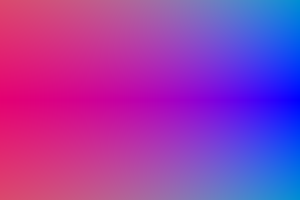

In [59]:
import numpy as np
import matplotlib.pyplot as plt

def normalize(vector):
    return vector / np.linalg.norm(vector)

width = 300
height = 200

camera = np.array([1, 0, 1])
ratio = float(width) / height
screen = (-1, 1 / ratio, 1, -1 / ratio) # left, top, right, bottom

d = np.zeros(shape=(height , width , 3))

image = np.zeros((height, width, 3))
for i, y in enumerate(np.linspace(screen[1], screen[3], height)):
    for j, x in enumerate(np.linspace(screen[0], screen[2], width)):
        pixel = np.array([x, y, 0])
        origin = camera
        direction = normalize(pixel - origin)
        d[i , j , :] = direction

        # image[i, j] = ...
    print("progress: %d/%d" % (i + 1, height))


from PIL import Image

i = ((np.abs(d))*255).astype(np.uint)

img = Image.fromarray(np.uint8(i))
img

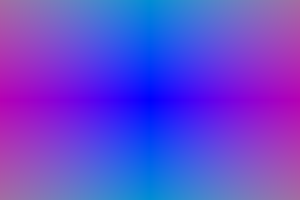

In [100]:
import numpy as np

f=20
height = 400
width=500

x = f*np.ones(shape=(height , width))
y = np.linspace(-height//2, height//2, height).astype(np.int32)
z = np.linspace(-width//2, width//2, width).astype(np.int32)

p = np.meshgrid(z , y)
# p = np.array([i.reshape((height ,width)) for i in p])
# p[: , height//2 , width//2]

p = np.array(p)
print(p.shape)
p_2 = (p*p).sum(axis=0 , keepdims=True)

(2, 400, 500)


In [103]:
p[0 , : , :]

array([[-250, -248, -247, ...,  247,  248,  250],
       [-250, -248, -247, ...,  247,  248,  250],
       [-250, -248, -247, ...,  247,  248,  250],
       ...,
       [-250, -248, -247, ...,  247,  248,  250],
       [-250, -248, -247, ...,  247,  248,  250],
       [-250, -248, -247, ...,  247,  248,  250]], dtype=int32)

In [79]:
nx, ny = (3, 2)
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
xv, yv = np.meshgrid(x, y)


In [11]:
y

array([0., 1.])